## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.pipeline import Pipeline
from utils import *

In [2]:
mailout_train = joblib.load(open('../data/mailout_train_clustered.pkl', "rb"))

In [3]:
print(mailout_train.shape)
mailout_train.head()

(42962, 321)


,DSL_FLAG,GREEN_AVANTGARDE,HH_DELTA_FLAG,KBA05_SEG6,KONSUMZELLE,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,ANREDE_KZ,OST_WEST_KZ,...,D19_KINDERARTIKEL,KBA05_KW2,KBA05_ZUL1,KBA05_ANTG2,KBA05_ANTG4,CJT_GESAMTTYP,SEMIO_FAM,VERDICHTUNGSRAUM,Cluster,RESPONSE
0,1.0,0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,W,...,0,4.0,3.0,0.0,2.0,2.0,2.0,4.0,3,0
1,1.0,0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,W,...,0,4.0,3.0,0.0,0.0,2.0,1.0,0.0,5,0
2,1.0,1,NaN,0.0,0.0,0.0,0.0,1.0,1.0,O,...,0,3.0,3.0,0.0,0.0,4.0,4.0,10.0,6,0
3,1.0,1,0.0,0.0,0.0,0.0,0.0,2.0,2.0,W,...,0,1.0,2.0,3.0,0.0,2.0,1.0,5.0,4,0
4,1.0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,W,...,0,4.0,3.0,0.0,1.0,6.0,6.0,4.0,4,0


### Build Classification Model

In [4]:
# Onehot encode Cluster column
X_clustered = mailout_train[['Cluster']]
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_clustered)
X_clustered_encoded = pd.DataFrame(enc.transform(X_clustered).toarray(), columns=list(enc.get_feature_names_out()))
X_clustered_encoded.head()

,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
mailout_train.drop(columns=['Cluster'], inplace=True)
mailout_train = mailout_train.join(X_clustered_encoded)

In [6]:
print(mailout_train.shape)
mailout_train.head()

(42962, 330)


,DSL_FLAG,GREEN_AVANTGARDE,HH_DELTA_FLAG,KBA05_SEG6,KONSUMZELLE,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,ANREDE_KZ,OST_WEST_KZ,...,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9
0,1.0,0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,W,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,W,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1,NaN,0.0,0.0,0.0,0.0,1.0,1.0,O,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,1,0.0,0.0,0.0,0.0,0.0,2.0,2.0,W,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,W,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [7]:
def randomize(df):
    """
    Returns randomized dataframes/series X and y.

    Input: df DataFrame
    Output: randomized dataframes/series X and y
    """

    df_randomized = df.sample(frac=1)
    y_rand = df_randomized['RESPONSE']
    X_rand = df_randomized.drop(['RESPONSE'], axis=1)
    return X_rand, y_rand

In [8]:
def draw_learning_curves(X, y, estimator, num_trainings):
    """
    Draw learning curve that shows the validation and training auc_score of an estimator
    for varying numbers of training samples.

    Input:
        X: array like sample
        y: array like target relative to X2 sample
        estimator: object type that implements the “fit” and “predict” methods
        num_trainings (int): number of training samples to plot

    Output:
        None
    """

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring='roc_auc', train_sizes=np.linspace(.1, 1.0, num_trainings))

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    print("AUC train score = {}".format(train_scores_mean[-1].round(2)))
    print("AUC validation score = {}".format(test_scores_mean[-1].round(2)))
    plt.grid()

    plt.title("Learning Curves")
    plt.xlabel("% of training set")
    plt.ylabel("Score")

    plt.plot(np.linspace(.1, 1.0, num_trainings) * 100, train_scores_mean, 'o-', color="g",
             label="Training score")
    plt.plot(np.linspace(.1, 1.0, num_trainings) * 100, test_scores_mean, 'o-', color="y",
             label="Cross-validation score")

    plt.yticks(np.arange(0.45, 1.02, 0.05))
    plt.xticks(np.arange(0., 100.05, 10))
    plt.legend(loc="best")
    print("")
    plt.show()

In [9]:
models = {'RandomForestClassifier': RandomForestClassifier(),
          'AdaBoostClassifier': AdaBoostClassifier(),
          'GradientBoostingClassifier': GradientBoostingClassifier()
          }

RandomForestClassifier
AUC train score = 0.97
AUC validation score = 0.59



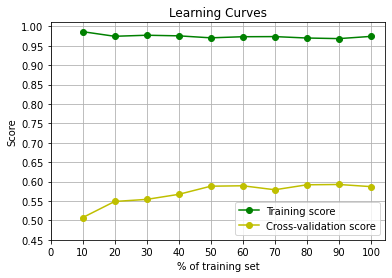

AdaBoostClassifier
AUC train score = 0.83
AUC validation score = 0.74



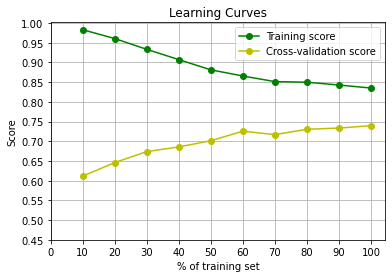

GradientBoostingClassifier
AUC train score = 0.91
AUC validation score = 0.75



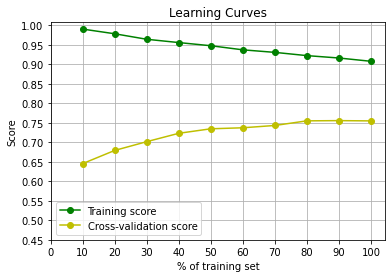

In [52]:
for model_key in models.keys():
    print(model_key)
    ml_pipeline = Pipeline([
        ('model', models[model_key])
    ])
    X, y = randomize(mailout_train)
    draw_learning_curves(X, y, ml_pipeline, 10)

In [202]:
X, y = randomize(mailout_train)
ada_clf = AdaBoostClassifier(n_estimators=100, random_state=0)
ada_clf.fit(X, y)

AdaBoostClassifier(random_state=42)

In [220]:
X, y = randomize(X_clustered_encoded.join(mailout_train[['RESPONSE']]))
gbc_clf = GradientBoostingClassifier(n_estimators=100, random_state=0)
gbc_clf.fit(X, y)

GradientBoostingClassifier(random_state=0)

In [74]:
#initialize with GradientBoostingClassifier
gbc_pipeline = Pipeline([
    ('gbc', AdaBoostClassifier(random_state=42))
])

parameters = {'gbc__learning_rate': [0.1, 0.2], 'gbc__n_estimators': [100],
             'gbc__max_depth': [3, 5], 'gbc__min_samples_split': [2,4]}        

start_time = time.time()
grid_obj = GridSearchCV(gbc_pipeline, parameters, scoring = 'roc_auc', verbose=50)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X, y)

elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100
[CV 1/5; 1/8] END gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100;, score=0.764 total time=  57.7s
[CV 2/5; 1/8] START gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100
[CV 2/5; 1/8] END gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100;, score=0.746 total time=  58.0s
[CV 3/5; 1/8] START gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100
[CV 3/5; 1/8] END gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100;, score=0.749 total time=  57.4s
[CV 4/5; 1/8] START gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100
[CV 4/5; 1/8] END gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_

GridSearchCV(estimator=Pipeline(steps=[('gbc',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'gbc__learning_rate': [0.1, 0.2],
                         'gbc__max_depth': [3, 5],
                         'gbc__min_samples_split': [2, 4],
                         'gbc__n_estimators': [100]},
             scoring='roc_auc', verbose=50)

In [155]:
print(grid_obj.best_score_)
print(grid_obj.best_estimator_)

0.7605260168365519
Pipeline(steps=[('gbc', GradientBoostingClassifier(random_state=42))])


In [136]:
#initialize with AdaBoostClassifier
clf = AdaBoostClassifier(DecisionTreeClassifier())
clf.get_params()

parameters = {'learning_rate': [0.1, 0.2], 'n_estimators': [50], 'random_state': [42],
             'base_estimator__max_depth': [1, 3], 'base_estimator__max_features': [20, None]}        

start_time = time.time()
ada_grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring = 'roc_auc', cv=5, n_jobs = 3, verbose=50)

# Fit the grid search object to the training data and find the optimal parameters
ada_grid_obj.fit(X, y)

elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Elapsed computation time: 7.002 mins


In [151]:
print(ada_grid_obj.best_score_)
print(ada_grid_obj.best_estimator_)

0.7625179146185074
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.1, random_state=42)


In [153]:
# save Gridsearch object
joblib.dump(grid_obj.best_estimator_, '../results/gbc_grids_obj.pkl')

['results/gbc_grids_obj.pkl']

In [152]:
# save Gridsearch object
joblib.dump(ada_grid_obj.best_estimator_, '../results/ada_grid_obj.pkl')

['results/ada_grid_obj.pkl']

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [2]:
mailout_test = joblib.load(open('../data/mailout_test_clean.pkl', "rb"))

In [3]:
print(mailout_test.shape)
mailout_test.head()

(42833, 320)


,LNR,DSL_FLAG,GREEN_AVANTGARDE,HH_DELTA_FLAG,KBA05_SEG6,KONSUMZELLE,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,ANREDE_KZ,...,KBA13_ALTERHALTER_30,KBA05_MAXVORB,D19_KINDERARTIKEL,KBA05_KW2,KBA05_ZUL1,KBA05_ANTG2,KBA05_ANTG4,CJT_GESAMTTYP,SEMIO_FAM,VERDICHTUNGSRAUM
0,1754,1.0,1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,3.0,1.0,0,3.0,3.0,1.0,0.0,5.0,4.0,23.0
1,1770,1.0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,4.0,3.0,0,4.0,3.0,2.0,1.0,1.0,4.0,0.0
2,1465,1.0,1,1.0,0.0,1.0,0.0,1.0,1.0,2.0,...,2.0,1.0,0,4.0,1.0,3.0,0.0,2.0,1.0,15.0
3,1470,1.0,0,NaN,0.0,0.0,0.0,0.0,2.0,2.0,...,2.0,2.0,0,2.0,3.0,1.0,0.0,4.0,1.0,10.0
4,1478,1.0,0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,...,3.0,3.0,5,2.0,4.0,0.0,0.0,6.0,2.0,0.0


In [4]:
test_identifier = mailout_test[['LNR']]

### Predict Customer Class

In [226]:
mailout_test_cluster = segment_clusters(mailout_test_clean, testset=True)

C:\Users\ADMIN\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.24.1 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\ADMIN\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator Pipeline from version 0.24.1 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\ADMIN\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.24.1 when using version 1.0. This might lead to breaking code or invalid

In [227]:
# Onehot encode Cluster column
X_clustered = mailout_test_cluster[['Cluster']]
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_clustered)
X_clustered_encoded = pd.DataFrame(enc.transform(X_clustered).toarray(), columns=list(enc.get_feature_names_out()))

In [103]:
mailout_test_cluster.drop(columns=['Cluster'], inplace=True)
mailout_test_cluster = mailout_test_cluster.join(X_clustered_encoded)

In [104]:
print(mailout_test_cluster.shape)
mailout_test_cluster.head()

(42833, 332)


,DSL_FLAG,GREEN_AVANTGARDE,HH_DELTA_FLAG,KBA05_SEG6,KONSUMZELLE,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,ANREDE_KZ,OST_WEST_KZ_O,...,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9
0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [166]:
# make prediction
# load model
# gbc_model = joblib.load('results/gbc_grids_obj.pkl')
# ada_model = joblib.load('results/ada_grid_obj.pkl')
ada_model = ada_grid_obj.best_estimator_

In [228]:
# mailout_test_proba = ada_clf.predict_proba(mailout_test_cluster)
mailout_test_proba = gbc_clf.predict_proba(X_clustered_encoded)
# mailout_test_proba = grid_obj.predict_proba(mailout_test_cluster)

In [229]:
mailout_test_proba

array([[0.98508734, 0.01491266],
       [0.98534021, 0.01465979],
       [0.98508734, 0.01491266],
       ...,
       [0.9892639 , 0.0107361 ],
       [0.98635439, 0.01364561],
       [0.9892639 , 0.0107361 ]])

In [230]:
proba_pred = pd.DataFrame(mailout_test_proba, columns=['proba_0', 'proba_1'])

In [231]:
proba_pred.apply(lambda x: 1 if x.proba_1>x.proba_0 else 0, axis=1).sum()

0

In [190]:
# mailout_test_pred = ada_model.predict(mailout_test_cluster)
mailout_test_pred = gbc_model.predict(mailout_test_cluster)

In [191]:
mailout_test_pred.sum()

23

In [192]:
test_identifier['RESPONSE'] = mailout_test_pred

C:\Users\ADMIN\AppData\Local\Temp/ipykernel_9264/733918308.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_identifier['RESPONSE'] = mailout_test_pred


In [193]:
test_identifier['RESPONSE'].sum()

23

In [194]:
test_identifier

,LNR,RESPONSE
0,1754,0
1,1770,0
2,1465,0
3,1470,0
4,1478,0
...,...,...
42828,67615,0
42829,67938,0
42830,67942,0
42831,67949,0


#### Create Submision

In [195]:
test_identifier.to_csv('results/submision_10282021_2.csv', index=False)